In [21]:
import liionpack as lp
import pandas as pd
import numpy as np
import pybamm
import os
import matplotlib.pyplot as plt
import datetime as dt

nproc = os.cpu_count()

In [22]:
N = 100
df = pd.read_csv(
    "C:\\Users\\daddyj\\Documents\\Batteryze\\Tarform\\src\\final_2022-08-04.log", index_col=0
)
df = df.iloc[:N]
df["timestamp"] = pd.to_datetime(df["timestamp"])
df["timestamp"] -= df["timestamp"][0]
df["timestamp"] = df["timestamp"].dt.total_seconds()
df["current"] *= -1

In [23]:
drive_cycle = df[["timestamp", "current"]].to_numpy()
drive_cycle = drive_cycle[drive_cycle[:,1]!=0]

In [24]:
experiment = pybamm.Experiment(
    operating_conditions=["Run 08_04 (A)"],
    drive_cycles={"08_04": drive_cycle},
    period="1 second",
)

In [25]:
Np = 32
Ns = 28
Nbatt = Np * Ns
V_max = 117
V_min = 77
I_discharge_max = 200
I_charge_max = 100  

OCV_init = 86.58 # used for intial guess
Ri_init = 5e-3  # used for intial guess
R_busbar = 1.5e-3
R_connection = 1e-2

netlist = lp.setup_circuit(
    Np=Np, Ns=Ns, Rb=R_busbar, Rc=R_connection, Ri=Ri_init, V=OCV_init
)

parameter_values = pybamm.ParameterValues("Chen2020")
SPMe = pybamm.models.full_battery_models.lithium_ion.SPMe()

output_variables = [
    "Voltage [V]",
]


In [26]:
parameter_values

{'Ambient temperature [K]': 298.15,
 'Boltzmann constant [J.K-1]': 1.380649e-23,
 'Bulk solvent concentration [mol.m-3]': 2636.0,
 'Cation transference number': 0.2594,
 'Cell cooling surface area [m2]': 0.00531,
 'Cell thermal expansion coefficient [m.K-1]': 1.1e-06,
 'Cell volume [m3]': 2.42e-05,
 'Contact resistance [Ohm]': 0,
 'Current function [A]': 5.0,
 'EC diffusivity [m2.s-1]': 2e-18,
 'EC initial concentration in electrolyte [mol.m-3]': 4541.0,
 'Electrode height [m]': 0.065,
 'Electrode width [m]': 1.58,
 'Electrolyte conductivity [S.m-1]': <function electrolyte_conductivity_Nyman2008 at 0x00000246971AC550>,
 'Electrolyte diffusivity [m2.s-1]': <function electrolyte_diffusivity_Nyman2008 at 0x00000246971AC5E0>,
 'Electron charge [C]': 1.602176634e-19,
 'Faraday constant [C.mol-1]': 96485.33212,
 'Ideal gas constant [J.K-1.mol-1]': 8.314462618,
 'Initial concentration in electrolyte [mol.m-3]': 1000.0,
 'Initial concentration in negative electrode [mol.m-3]': 29866.0,
 'Initi

In [27]:
parameter_values['Nominal cell capacity [A.h]'] = 3.0
parameter_values['Lower voltage cut-off [V]'] = 3.08
parameter_values['Electrode width [m]'] = 0.58
#parameter_values['Cell volume [m3]'] = 1.3e-05


In [28]:

output = lp.solve(
    netlist=netlist,
    parameter_values=parameter_values,
    experiment=experiment,
    output_variables=output_variables,
    initial_soc=0,
    nproc = 1
)

Stepping simulation: 100%|██████████| 97/97 [03:00<00:00,  1.86s/it]


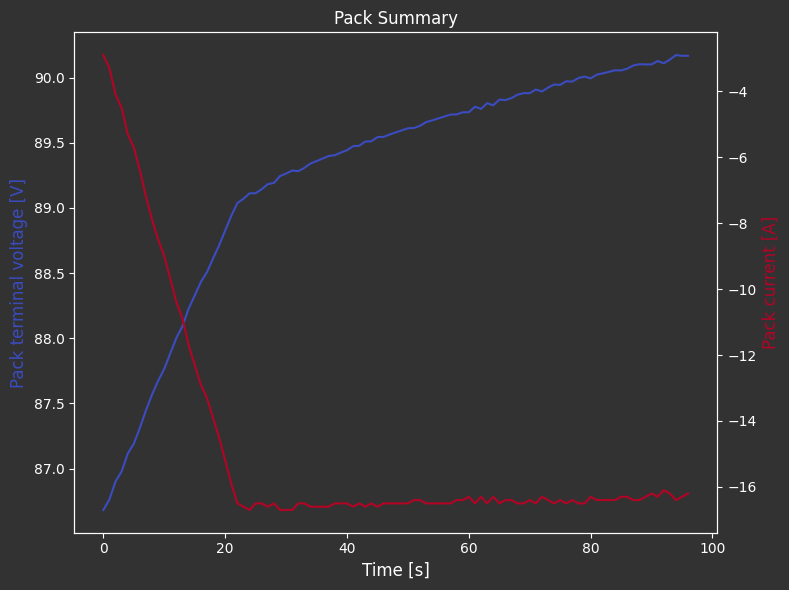

In [29]:

lp.plot_pack(output)
lp.show_plots()


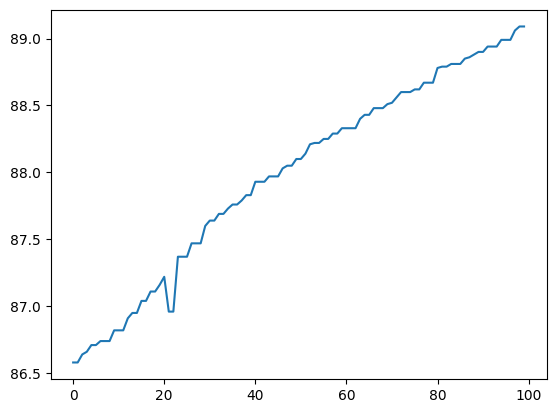

In [30]:
plt.plot(df["timestamp"], df["voltage"])
#plt.plot(df["timestamp"], -6*df["current"])
plt.show()